<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_Model_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Model based on Pix2Pix structure

utilizes Unet generator with skip connections

pix2pix tutorial (Unet generator example)  https://www.tensorflow.org/tutorials/generative/pix2pix

"""

# Library Imports and Data Access

In [1]:
import tensorflow as tf

import os
import shutil
import time
import datetime
from matplotlib import pyplot as plt
import numpy as np

from IPython import display
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
## Test that GPU is enabled

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## Check available memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [8]:
## Check GPU memory

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=d6448ccc01ffbc957fb952e5a51d54a2046940696467c2a70f921298d4605d05
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 25.6 GB  | Proc size: 1.2 GB
GPU RAM Free: 11601MB | Used: 4529MB | Util  28% | Total 16130MB


In [3]:
### Use gdown to copy zip files to local VM
## Unpack zip files on local VM

!gdown --id 17fOY0p2RayzycBCcdBAwD1n0dsZ2gaRr
!gdown --id 17-He-AtD-BtPslRAspWe0Dh8eH-Taa5i

_2D_folder_local = '/content/2D_Production_Min10_Max1_Training-20201023T183007Z-001.zip'
_2D_target_dir = '/content/2D_training'

_3D_folder_local = '/content/3D_Production_Min10_Max1_Training-20201023T182958Z-001.zip'
_3D_target_dir = '/content/3D_training'

shutil.unpack_archive(_2D_folder_local, _2D_target_dir)
shutil.unpack_archive(_3D_folder_local, _3D_target_dir)

# Print sizes of training directories
total = 0
for path, dirs, files in os.walk(_2D_target_dir):
    for f in files:
        fp = os.path.join(path, f)
        total += os.path.getsize(fp)
print("Size of 2D directory: ", (total/1000000), "MB")

total = 0
for path, dirs, files in os.walk(_3D_target_dir):
    for f in files:
        fp = os.path.join(path, f)
        total += os.path.getsize(fp)
print("Size of 3D directory: ", (total/1000000), "MB")


## Links to zip files on Drive
# 2D zip
# https://drive.google.com/file/d/17fOY0p2RayzycBCcdBAwD1n0dsZ2gaRr/view?usp=sharing

# 3D zip 
# https://drive.google.com/file/d/17-He-AtD-BtPslRAspWe0Dh8eH-Taa5i/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17fOY0p2RayzycBCcdBAwD1n0dsZ2gaRr
To: /content/2D_Production_Min10_Max1_Training-20201023T183007Z-001.zip
166MB [00:01, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=17-He-AtD-BtPslRAspWe0Dh8eH-Taa5i
To: /content/3D_Production_Min10_Max1_Training-20201023T182958Z-001.zip
155MB [00:01, 106MB/s] 
Size of 2D directory:  159.786722 MB
Size of 3D directory:  148.51073 MB


# Data Preparation

In [4]:
## Parameters used throughout Preparation and Model Build

BUFFER_SIZE = 350
BATCH_SIZE = 64
IMG_SIZE0 = 256    # Initial model implementation only works with 256x256 - revisit up/down layers for other sizes
IMG_SIZE1 = 256
OUTPUT_CHANNELS = 3

In [5]:
# ## Define drive locations (if streaming from mounted Drive)
# _2D_imgs_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run1/2D_Production_Min10_Max1_Training"
# _3D_imgs_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run1/3D_Production_Min10_Max1_Training"

## Define local VM paths to image files
_2D_imgs_path = '/content/2D_training/2D_Production_Min10_Max1_Training'
_3D_imgs_path = '/content/3D_training/3D_Production_Min10_Max1_Training'


start = time.time()
## Iterate through folders, create list of filepaths for images
TwoDImages = []
for root, dirs, files in os.walk(_2D_imgs_path):
      for name in files:
          if name.endswith(".png"):
              filename = os.path.join(root, name)
              TwoDImages.append(filename)

ThreeDImages = []
for root, dirs, files in os.walk(_3D_imgs_path):
      for name in files:
          if name.endswith(".png"):
              filename = os.path.join(root, name)
              ThreeDImages.append(filename)

TwoDImages = sorted(TwoDImages, key=lambda x: int(x.split('/')[-1].split('_')[0]))
ThreeDImages = sorted(ThreeDImages, key=lambda x: int(x.split('/')[-1].split('_')[0]))

##### !!!!!!!!! Defining training set size to fit into GPU memory
TwoDImages = TwoDImages[:1920]
ThreeDImages = ThreeDImages[:1920]


end = time.time()
print("Time to completion (s): ", end-start)

Time to completion (s):  0.1442418098449707


In [6]:
## Check size of file lists, check that trace pair number (leading digits)
## is same between 2D and 3D file

print(len(TwoDImages))
print(len(ThreeDImages))
print(TwoDImages[-1])
print(ThreeDImages[-1])

1920
1920
/content/2D_training/2D_Production_Min10_Max1_Training/2919_1243601000_2D_331.png
/content/3D_training/3D_Production_Min10_Max1_Training/2919_1243601000_3D_172285.png


In [7]:
######
# Create TensorFLow Dataset from images
######



# Load the png file, cast to tensor
def load(image):
    img = Image.open(image)
    img = np.array(img)
    img=img[:,:,:-1]    # using the -1 index to drop the 4th alpha value from png
    img= tf.cast(img, tf.float32)

    return img

# Normalize image to between -1 --> 1
def normalize(input_image):
    input_image = (input_image / 127.5) - 1

    return input_image

# Perform load and normalize the png
def load_image_train(image):
    img = load(image)
    img = normalize(img)

    return img


start = time.time()
# Load images using functions above
tr_data3d = []

for img in ThreeDImages:
    tmp = load_image_train(img)
    tr_data3d.append(tmp)
    
tr_data2d = []
for img in TwoDImages:
    tmp = load_image_train(img)
    tr_data2d.append(tmp)

end = time.time()
print("Time to completion (s): ", end-start)


Time to completion (s):  14.203072786331177


In [9]:
### Creates tensors of shape (BATCH_SIZE, 256, 256, 3)
start = time.time()

train_dataset2d_0 = tf.data.Dataset.from_tensor_slices(tr_data2d)
train_dataset2d = train_dataset2d_0.batch(BATCH_SIZE)

train_dataset3d_0 = tf.data.Dataset.from_tensor_slices(tr_data3d)
train_dataset3d = train_dataset3d_0.batch(BATCH_SIZE)

end = time.time()
print("Time to completion (s): ", end-start)

Time to completion (s):  2.201935052871704


# Define Deep Learning Model Architecture

In [10]:
# Define and instantiate discriminator and generator models

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result



def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Instantiate the models
generator = Generator()
discriminator = Discriminator()

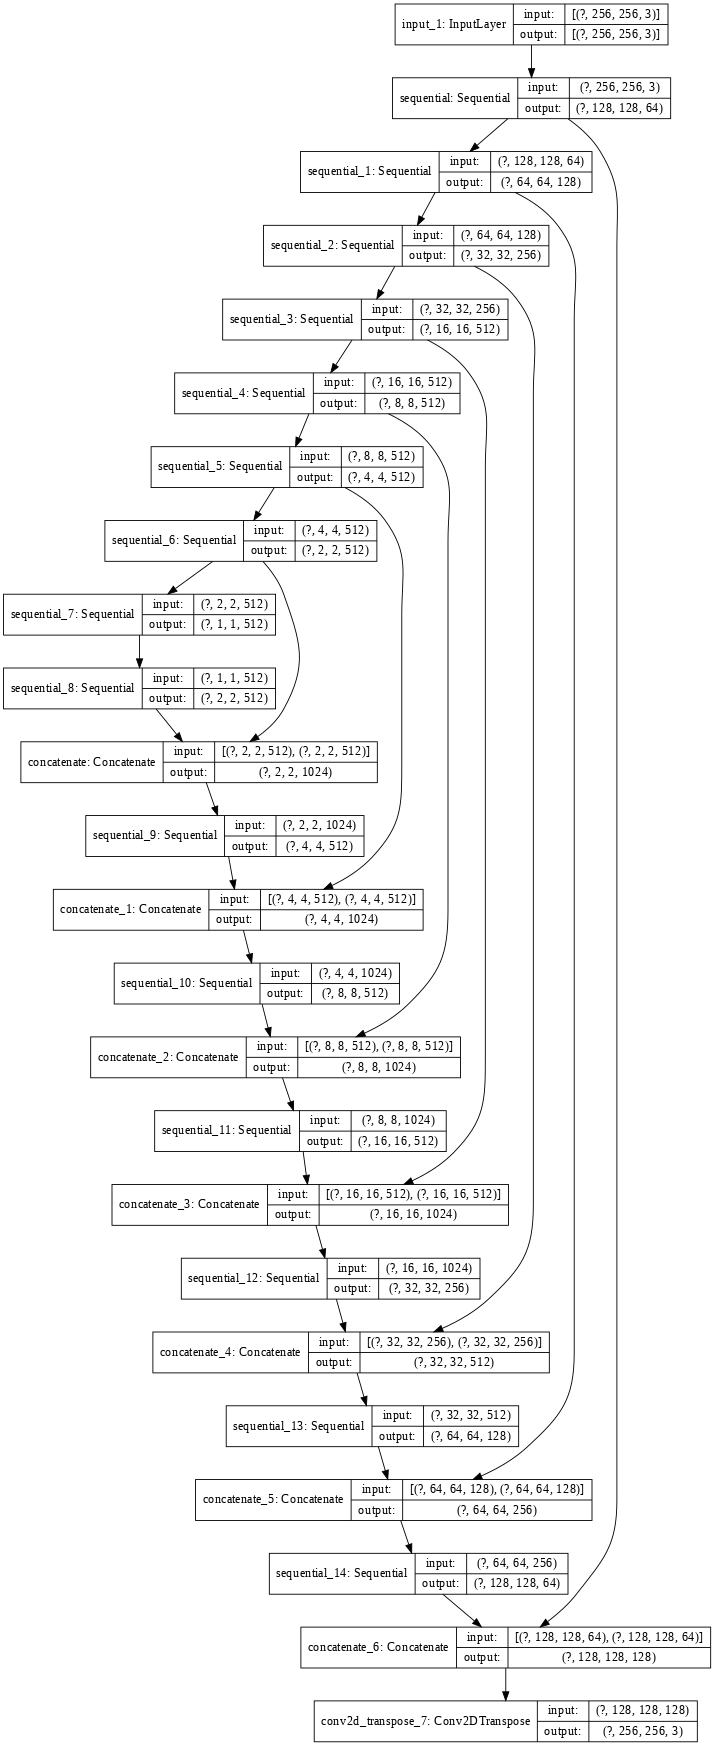

In [ ]:
## Display graphical model description

# Generator().summary()
# Discriminator().summary()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [11]:
# define loss and optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss



generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define Training Steps and Checkpoints

In [12]:
# set up checkpoints and define training step

log_dir="/content/drive/My Drive/RadNET/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


#### summary writer not working locally, test on Colab?
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [13]:
def fit(train_3d, train_2d, epochs, chkpt_save):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        try:
            print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                        time.time()-start))
        except:
            pass

        start = time.time()
        print("Epoch ", epoch, " running...")

        
#         # Train (combined Dataset)
#         for n, (input_image, target) in train_ds.enumerate():
#             print('.', end='')
#             if (n+1) % 100 == 0:
#                 print()
#             train_step(input_image, target, epoch)
#         print()

        n=0
        # Train (separate Datasets for input and target)
        for input_image, target in tf.data.Dataset.zip((train_3d, train_2d)):
            train_step(input_image, target, epoch)
            if (n+1) % 100 == 0:
                print('.', end='')
            n +=1 
    
    
#         for n, input_image in train_3d.enumerate():
#             print('.', end='')
#             if (n+1) % 100 == 0:
#                 print()
#             for m, target in train_3d.enumerate():
#                 if m==n:
#                     train_step(input_image, target, epoch)
                    
        print()

        


    # saving (checkpoint) the model every chkpt_save epochs
        if (epoch + 1) % chkpt_save == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    checkpoint.save(file_prefix = checkpoint_prefix)

# Train the Model

In [ ]:
# Load latest checkpoint if picking up / continuing training 
# Skip if starting from scratch

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [14]:
# Define how many epochs to run model
EPOCHS = 500
chkpt_save = 100

# Run the model
fit(train_dataset3d, train_dataset2d, EPOCHS, chkpt_save)

print("Training Complete!")

Time taken for epoch 461 was 17.95277690887451 sec

Epoch  462  running...


ResourceExhaustedError: ignored

# Run Predictions on Test Dataset

In [ ]:
# 3D test images to enhance
_3D_test_path = "/content/drive/My Drive/RadNET/GAN data/Dev_Testing_Data/3D_testing"
output_prediction_path = "/content/drive/My Drive/RadNET/GAN data/Dev_Testing_Data/Test_Predictions/"

TestImages = []
for root, dirs, files in os.walk(_3D_test_path):
    for name in files:
        if name.endswith(".png"):
            filename = os.path.join(root, name)
            name = name.split('.')[0]
            TestImages.append([name, filename])

## Make sure these parameters match image generation step
colormap = 'jet'
min_val = -10
max_val = 0
shading = 'flat'

for i in TestImages:
    im3d = load_image_train(i[1])
    testing = np.expand_dims(im3d, axis=0)
    model_test = generator.predict(testing)
    model_test = np.squeeze(model_test)
    model_test = (model_test + 1) * 127.5
    model_test = model_test.astype(np.uint8)
    plt.imsave(output_prediction_path + str(i[0]) + "_prediction.png", 
               model_test, cmap=colormap, vmin=min_val, vmax=max_val)